In [232]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.api import VAR
from statsmodels.tsa.ar_model import AutoReg
import random
import warnings

In [233]:
data2012 = pd.read_csv("daily-treasury-rates (18).csv").iloc[::-1]
data2013 = pd.read_csv("daily-treasury-rates (11).csv").iloc[::-1]
data2014 = pd.read_csv("daily-treasury-rates (12).csv").iloc[::-1]
data2015 = pd.read_csv("daily-treasury-rates (13).csv").iloc[::-1]
data2016 = pd.read_csv("daily-treasury-rates (14).csv").iloc[::-1]
data2017 = pd.read_csv("daily-treasury-rates (15).csv").iloc[::-1]
data2018 = pd.read_csv("daily-treasury-rates (16).csv").iloc[::-1]

all_data = pd.concat([data2012, data2013, data2014, data2015, data2016, data2017, data2018], ignore_index=True)
all_data = all_data.drop(columns=['2 Mo', '5 Yr', '7 Yr', '10 Yr', '20 Yr', '30 Yr'])
all_data.iloc[:, 1:] = all_data.iloc[:, 1:] / 100

all_data['b1'] = 0
all_data['b2'] = 0
all_data['b3'] = 0

In [234]:
all_data

,Date,1 Mo,3 Mo,6 Mo,1 Yr,2 Yr,3 Yr,b1,b2,b3
0,01/03/2012,0.0001,0.0002,0.0006,0.0012,0.0027,0.0040,0,0,0
1,01/04/2012,0.0001,0.0002,0.0006,0.0012,0.0025,0.0040,0,0,0
2,01/05/2012,0.0001,0.0002,0.0007,0.0011,0.0027,0.0040,0,0,0
3,01/06/2012,0.0002,0.0002,0.0005,0.0012,0.0025,0.0040,0,0,0
4,01/09/2012,0.0001,0.0001,0.0005,0.0011,0.0026,0.0038,0,0,0
...,...,...,...,...,...,...,...,...,...,...
1745,12/24/2018,0.0242,0.0245,0.0252,0.0261,0.0255,0.0256,0,0,0
1746,12/26/2018,0.0241,0.0244,0.0254,0.0261,0.0261,0.0260,0,0,0
1747,12/27/2018,0.0243,0.0241,0.0249,0.0258,0.0256,0.0255,0,0,0
1748,12/28/2018,0.0239,0.0240,0.0248,0.0257,0.0252,0.0250,0,0,0


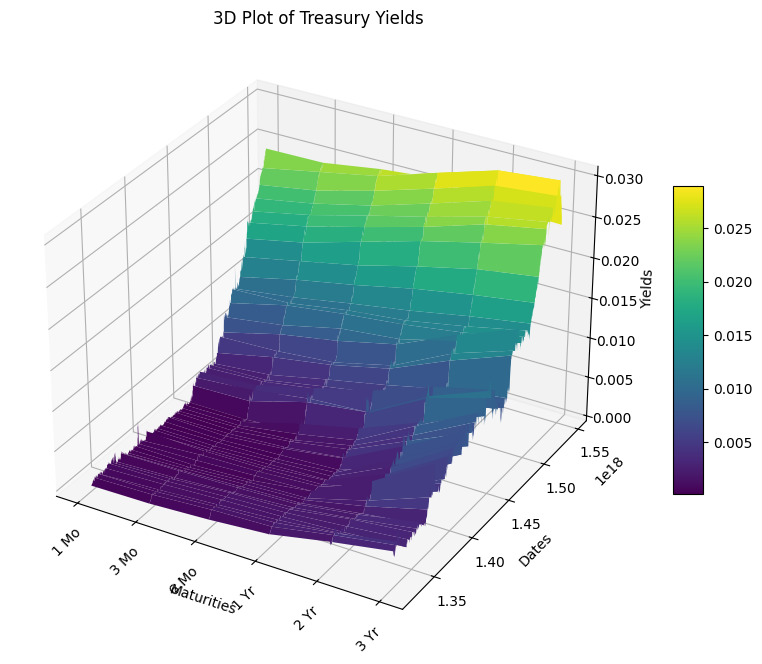

In [235]:
# AI generated code for plotting

all_data['Date'] = pd.to_datetime(all_data['Date'])

# Convert maturities and yields
dates = pd.to_numeric(all_data['Date'])  # Numeric representation of dates
maturities = list(all_data.columns[1:7])  # Column headers as maturities
yields = all_data.iloc[:, 1:7].values  # Yield values as a 2D array

# Create a meshgrid for plotting
X, Y = np.meshgrid(range(len(maturities)), dates)
Z = yields

# Plotting
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Create a 3D surface plot
surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')

# Set labels and title
ax.set_title("3D Plot of Treasury Yields")
ax.set_xlabel("Maturities")
ax.set_ylabel("Dates")
ax.set_zlabel("Yields")
ax.set_xticks(range(len(maturities)))
ax.set_xticklabels(maturities, rotation=45)
fig.colorbar(surf, shrink=0.5, aspect=10)

plt.show()

In [236]:
all_data.replace([np.inf, -np.inf], np.nan, inplace=True)
all_data.dropna(inplace=True)

In [242]:
 def NelsonSiegel(t,b1,b2,b3):
    lambd = 0.0609/365
    return b1 + b2*((1-np.exp(-lambd*t))/(lambd*t)) + b3*((1-np.exp(-lambd*t))/(lambd*t) - np.exp(-lambd*t))

def generateParams(df):
    for i in range(len(df)):
        params, pcov = optimize.curve_fit(NelsonSiegel,
            xdata = np.array([1,3,6,12,24,36]) * 30.4,
            ydata = df.iloc[i,1:7],
            p0 = [0.1,0.2,0.3])
        b1,b2,b3 = params
        df.at[i,'b1'] = b1
        df.at[i,'b2'] = b2
        df.at[i,'b3'] = b3
    return df.iloc[:,7:10].reset_index(drop=True)

In [243]:
data = generateParams(all_data)

In [244]:
result = adfuller(data['b1'])
print('p-val b1: ', result[1])

result = adfuller(data['b2'])
print('p-val b2: ', result[1])

result = adfuller(data['b3'])
print('p-val b3: ', result[1])

p-val b1:  0.6623063488365231
p-val b2:  0.6675027583701549
p-val b3:  0.650330917848073


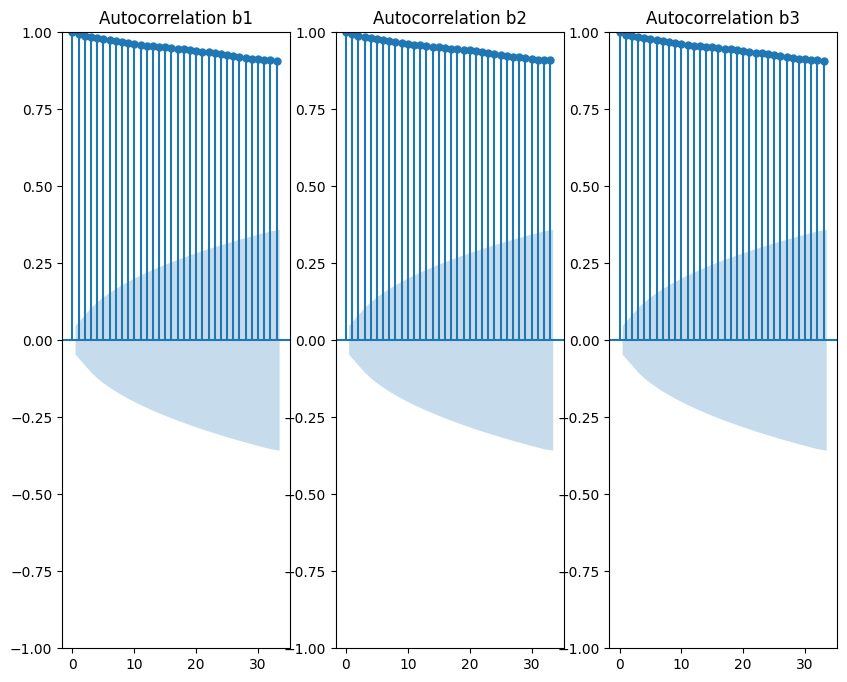

In [245]:
fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(131)
plot_acf(data['b1'], ax)
plt.title('Autocorrelation b1')
bx = fig.add_subplot(132)
plot_acf(data['b2'], bx)
plt.title('Autocorrelation b2')
cx = fig.add_subplot(133)
plot_acf(data['b3'], cx)
plt.title('Autocorrelation b3')

plt.show()

In [246]:
# Fit AR(1) models to predict the 1030th curve from 1000

model_beta1 = AutoReg(data['b1'][:1000],lags=1)
fit_beta1 = model_beta1.fit()
forecast_beta1 = fit_beta1.forecast(steps=30).iloc[-1]
print('beta 1: ', forecast_beta1)

model_beta2 = AutoReg(data['b2'][:1000],lags=1)
fit_beta2 = model_beta2.fit()
forecast_beta2 = fit_beta2.forecast(steps=30).iloc[-1]
print('beta 2: ', forecast_beta2)

model_beta3 = AutoReg(data['b3'][:1000],lags=1)
fit_beta3 = model_beta3.fit()
forecast_beta3 = fit_beta3.forecast(steps=30).iloc[-1]
print('beta 3: ', forecast_beta3)

beta 1:  -0.8370040235400195
beta 2:  0.8384908920865233
beta 3:  1.0410491893532714


In [247]:
# Construct VAR model for comparison
model_VAR = VAR(all_data.iloc[:1000,1:7])
results = model_VAR.fit(maxlags=1,ic='aic')

In [248]:
forecast = results.forecast(y=all_data.iloc[999:1000,1:7].values,steps=30)[-1]
forecast

array([0.00115363, 0.0018851 , 0.00504428, 0.00769751, 0.01150174,
       0.01363676])

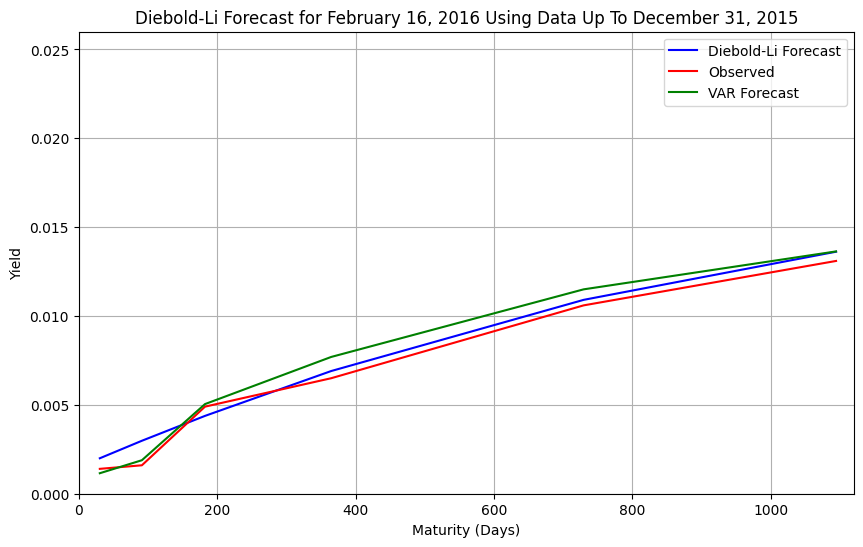

In [249]:
t = np.array([1,3,6,12,24,36]) * 30.4

df = pd.DataFrame({'maturities': t})
df['yield'] = NelsonSiegel(df['maturities'],forecast_beta1,forecast_beta2,forecast_beta3)
    
plt.figure(figsize=(10, 6))
plt.plot(df['maturities'],df['yield'],label='Diebold-Li Forecast',color='blue')
plt.plot(df['maturities'], all_data.iloc[1000,1:7],label='Observed',color='red')
plt.plot(df['maturities'],forecast.flatten(),label='VAR Forecast',color='green')

plt.xlabel('Maturity (Days)')
plt.xlim(0,1120)

plt.ylabel('Yield')
plt.ylim(0,0.026)

plt.title('Diebold-Li Forecast for February 16, 2016 Using Data Up To December 31, 2015')
plt.grid(True)
plt.legend()
plt.show()

beta 1:  -0.4138407842965583
beta 2:  0.41612827119232504
beta 3:  0.5784807918744916


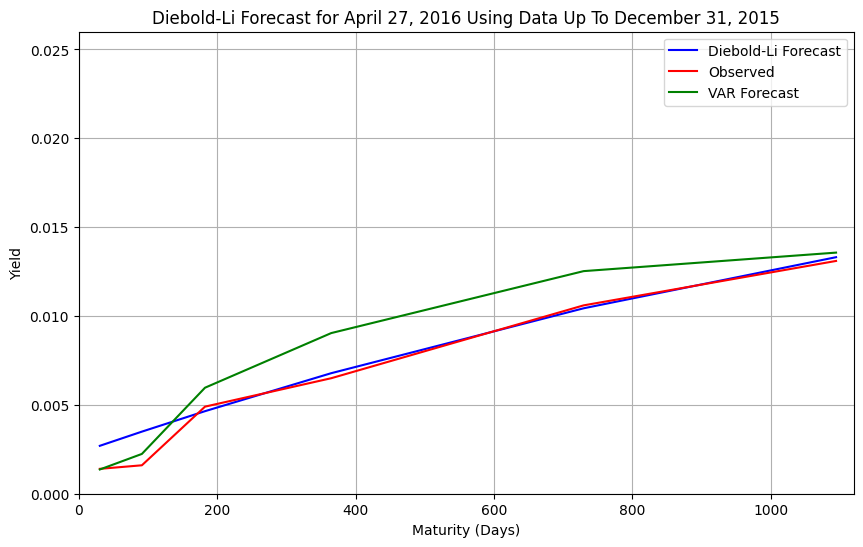

In [252]:
model_beta1 = AutoReg(data['b1'][:1000],lags=1)
fit_beta1 = model_beta1.fit()
forecast_beta1 = fit_beta1.forecast(steps=80).iloc[-1]
print('beta 1: ', forecast_beta1)

model_beta2 = AutoReg(data['b2'][:1000],lags=1)
fit_beta2 = model_beta2.fit()
forecast_beta2 = fit_beta2.forecast(steps=80).iloc[-1]
print('beta 2: ', forecast_beta2)

model_beta3 = AutoReg(data['b3'][:1000],lags=1)
fit_beta3 = model_beta3.fit()
forecast_beta3 = fit_beta3.forecast(steps=80).iloc[-1]
print('beta 3: ', forecast_beta3)

model_VAR = VAR(all_data.iloc[:1000,1:7])
results = model_VAR.fit(maxlags=1,ic='aic')

forecast = results.forecast(y=all_data.iloc[999:1000,1:7].values,steps=80)[-1]

t = np.array([1,3,6,12,24,36]) * 30.4

df = pd.DataFrame({'maturities': t})
df['yield'] = NelsonSiegel(df['maturities'],forecast_beta1,forecast_beta2,forecast_beta3)
    
plt.figure(figsize=(10, 6))
plt.plot(df['maturities'],df['yield'],label='Diebold-Li Forecast',color='blue')
plt.plot(df['maturities'], all_data.iloc[1000,1:7],label='Observed',color='red')
plt.plot(df['maturities'],forecast.flatten(),label='VAR Forecast',color='green')

plt.xlabel('Maturity (Days)')
plt.xlim(0,1120)

plt.ylabel('Yield')
plt.ylim(0,0.026)

plt.title('Diebold-Li Forecast for April 27, 2016 Using Data Up To December 31, 2015')
plt.grid(True)
plt.legend()
plt.show()

In [251]:
all_data.iloc[1080]

Date    2016-04-27 00:00:00
1 Mo                 0.0018
3 Mo                 0.0024
6 Mo                  0.004
1 Yr                 0.0058
2 Yr                 0.0083
3 Yr                 0.0099
b1                  -1.0254
b2                 1.026788
b3                 1.195607
Name: 1080, dtype: object

In [204]:
data2019 = pd.read_csv("daily-treasury-rates (19).csv")[::-1]
data2019 = data2019.drop(columns=['2 Mo', '5 Yr', '7 Yr', '10 Yr', '20 Yr', '30 Yr'])
data2019.iloc[:, 1:] = data2019.iloc[:, 1:] / 100

data2019['b1'] = 0
data2019['b2'] = 0
data2019['b3'] = 0

beta 1:  0.5086294546631518
beta 2:  -0.4888505491824985
beta 3:  -0.5589802964250122


/var/folders/yk/l64w5c2s01l4zktkbrqwbf1r0000gn/T/ipykernel_72742/140393308.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-1.041769118615051' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.at[i,'b1'] = b1
/var/folders/yk/l64w5c2s01l4zktkbrqwbf1r0000gn/T/ipykernel_72742/140393308.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.0657080472106868' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.at[i,'b2'] = b2
/var/folders/yk/l64w5c2s01l4zktkbrqwbf1r0000gn/T/ipykernel_72742/140393308.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.1394314118324722' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df

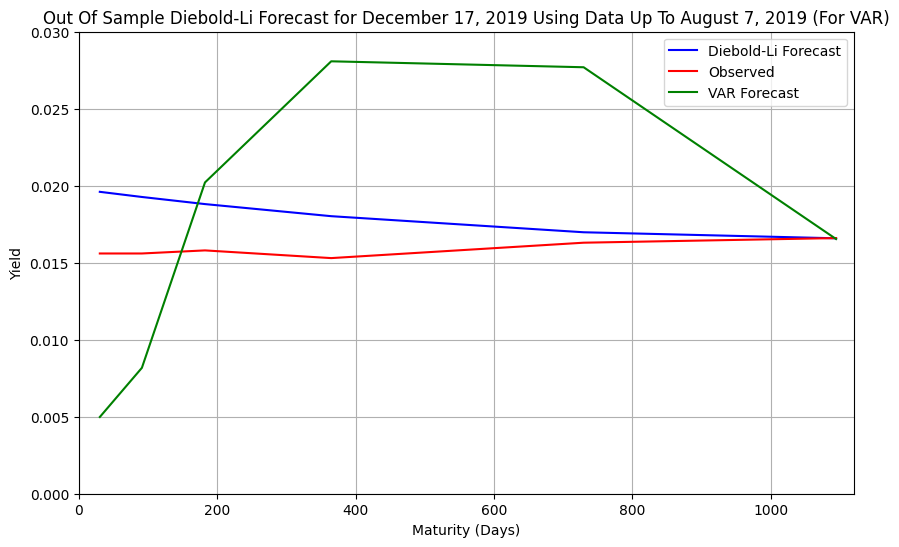

In [205]:
data = generateParams(data2019)

model_beta1 = AutoReg(data2019['b1'][:150],lags=1)
fit_beta1 = model_beta1.fit()
forecast_beta1 = fit_beta1.forecast(steps=90).iloc[-1]
print('beta 1: ', forecast_beta1)

model_beta2 = AutoReg(data2019['b2'][:150],lags=1)
fit_beta2 = model_beta2.fit()
forecast_beta2 = fit_beta2.forecast(steps=90).iloc[-1]
print('beta 2: ', forecast_beta2)

model_beta3 = AutoReg(data2019['b3'][:150],lags=1)
fit_beta3 = model_beta3.fit()
forecast_beta3 = fit_beta3.forecast(steps=90).iloc[-1]
print('beta 3: ', forecast_beta3)

forecast = results.forecast(data2019.iloc[149:150,1:7].values,steps=90)[-1]

t = np.array([1,3,6,12,24,36]) * 30.4

df = pd.DataFrame({'maturities': t})
df['yield'] = NelsonSiegel(df['maturities'],forecast_beta1,forecast_beta2,forecast_beta3)
    
plt.figure(figsize=(10, 6))
plt.plot(df['maturities'],df['yield'],label='Diebold-Li Forecast',color='blue')
plt.plot(df['maturities'], data2019.iloc[240,1:7],label='Observed',color='red')
plt.plot(df['maturities'],forecast.flatten(),label='VAR Forecast',color='green')

plt.xlabel('Maturity (Days)')
plt.xlim(0,1120)

plt.ylabel('Yield')
plt.ylim(0,0.03)

plt.title('Out Of Sample Diebold-Li Forecast for December 17, 2019 Using Data Up To August 7, 2019 (For VAR)')
plt.grid(True)
plt.legend()
plt.show()

In [230]:
warnings.simplefilter('ignore')

def RMSE(actual,pred):
    size = len(actual)
    accumulator = 0
    for i in range(len(actual)):
        accumulator += np.sqrt((actual[i] - pred[i])**2 / size)
    return accumulator
    
def MCSamplingRMSE(df,iterations):

    for i in range(iterations):
        ran = random.randint(20,219)
        VAR_rmse = 0
        DL_rmse = 0

        dfparams = generateParams(df)
        
        model_beta1 = AutoReg(dfparams['b1'][:ran],lags=1)
        fit_beta1 = model_beta1.fit()
        forecast_beta1 = fit_beta1.forecast(steps=30).iloc[-1]

        model_beta2 = AutoReg(dfparams['b2'][:ran],lags=1)
        fit_beta2 = model_beta2.fit()
        forecast_beta2 = fit_beta2.forecast(steps=30).iloc[-1]

        model_beta3 = AutoReg(dfparams['b3'][:ran],lags=1)
        fit_beta3 = model_beta3.fit()
        forecast_beta3 = fit_beta3.forecast(steps=30).iloc[-1]
        
        forecast_VAR = results.forecast(df.iloc[ran-1:ran,1:7].values,steps=30)[-1]
        forecast_DL = NelsonSiegel(np.array([1,3,6,12,24,36]) * 30.4,forecast_beta1,forecast_beta2,forecast_beta3)
        slice = df.iloc[ran+30,1:7]
        
        VAR_rmse += RMSE(slice,forecast_VAR)
        DL_rmse += RMSE(slice,forecast_DL)
        
    print("VAR out of sample RMSE: ", VAR_rmse)
    print("DL out of sample RMSE: ", DL_rmse)    

In [231]:
MCSamplingRMSE(data2019,120)

VAR out of sample RMSE:  0.01609685312200426
DL out of sample RMSE:  0.005868541227778114


In [2]:
import yfinance as yf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from pypfopt import risk_models
from pypfopt import black_litterman
from pypfopt import BlackLittermanModel
from pypfopt import EfficientFrontier
from pypfopt import objective_functions

[*********************100%%**********************]  8 of 8 completed
[*********************100%%**********************]  1 of 1 completed


<Axes: xlabel='Ticker', ylabel='Ticker'>

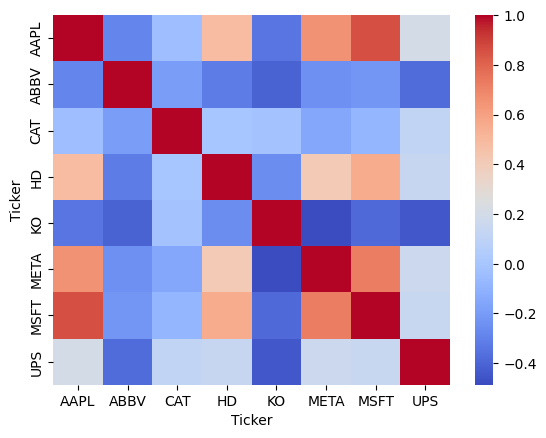

In [3]:
symbols = ['AAPL','MSFT','META','KO','UPS','CAT','ABBV','HD']

portfolio = yf.download(symbols,start='2018-01-01',end='2023-02-28')['Adj Close']
market_prices = yf.download('SPY',start='2018-01-01',end='2023-02-28')['Adj Close']

#Get market caps
mcaps = {}
for t in symbols:
    mcaps[t] = yf.Ticker(t).info['marketCap']
mcaps

S = risk_models.CovarianceShrinkage(portfolio).ledoit_wolf()
delta = black_litterman.market_implied_risk_aversion(market_prices)

sns.heatmap(S.corr(),cmap='coolwarm')

In [5]:
market_prior = black_litterman.market_implied_prior_returns(mcaps,delta,S)

viewdict = {'AAPL': 0.10, 'MSFT': 0.10, 'META': 0.05, 
            'KO': 0.1, 'UPS': 0.05, 'CAT': 0.3, 'HD': 0.1,}

intervals = [
    (-0.65,0.85),
    (-0.65,0.85),
    (0.15,0.2),
    (-0.2,0.5),
    (0.3,0.4),
    (0.01,0.3),
    (0.1,0.1)
]

variances = []
for lb, ub in intervals:
    sigma = (ub-lb)/2
    variances.append(sigma ** 2)

omega = np.diag(variances)

bl = BlackLittermanModel(S, pi='market', market_caps=mcaps, risk_aversion=delta,
                         absolute_views=viewdict, omega=omega)

<Axes: >

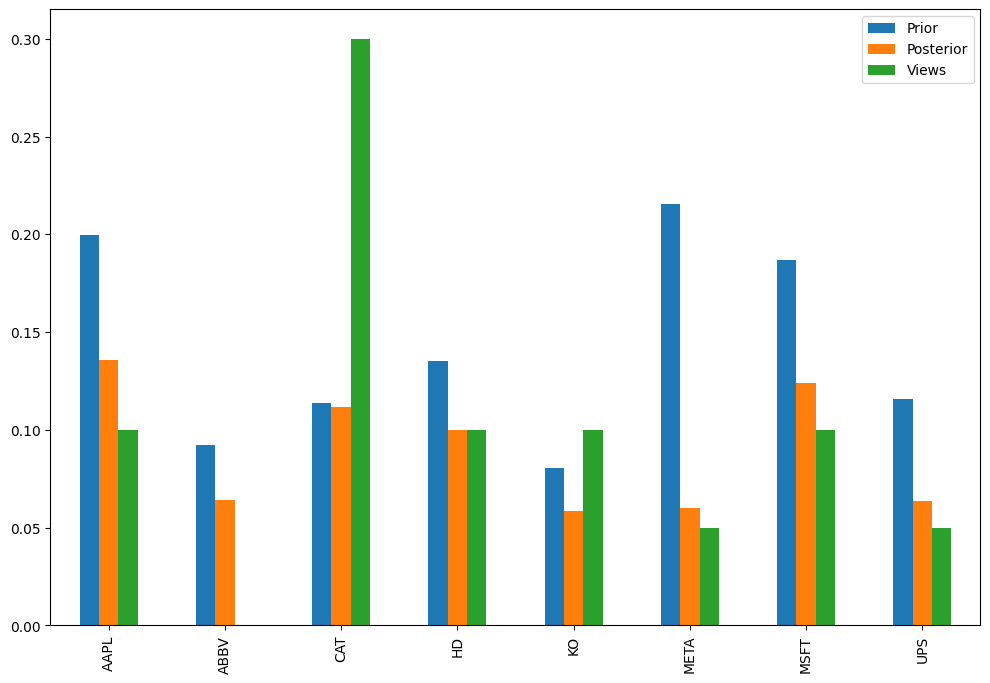

In [8]:
ret_bl = bl.bl_returns()
S_bl = bl.bl_cov()

rets_df = pd.DataFrame([market_prior, ret_bl, pd.Series(viewdict)],
                      index=["Prior","Posterior","Views"]).T

rets_df.plot.bar(figsize=(12,8))

OrderedDict({'AAPL': 0.22554, 'ABBV': 0.07669, 'CAT': 0.17773, 'HD': 0.15057, 'KO': 0.06745, 'META': 0.03699, 'MSFT': 0.19944, 'UPS': 0.06558})
Expected annual return: 10.5%
Annual volatility: 23.8%
Sharpe Ratio: 0.36


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(


(0.105404827113283, 0.23769155838149472, 0.3593094668352013)

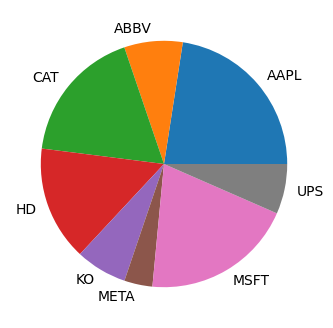

In [9]:
ef = EfficientFrontier(ret_bl, S_bl)
ef.add_objective(objective_functions.L2_reg)
ef.max_sharpe()
weights = ef.clean_weights()
print(weights)

pd.Series(weights).plot.pie(figsize=(4,4))

ef.portfolio_performance(verbose=True,risk_free_rate=0.009)